## Time-series based analysis of Earthquake Risk Factors

### Part 4: Performing linear regression

Importing the required libraries:

In [16]:
import requests
import json
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score


import datetime as dt

import seaborn as sns



import pickle

### Part 2.1: Prepping Loma Prieta EQ's:

In [17]:
file_path = "../datasets/" + "eq_loma_prieta" + "_clean" + ".csv"

df_lp = pd.read_csv(file_path)
df_lp.drop(columns = "Unnamed: 0", inplace = True)

df_lp["time"] = pd.to_datetime(df_lp["time"])

df_lp.sort_values(by = "time", inplace=True)


df_lp.reset_index(drop = True, inplace=True)
df_lp.drop(columns = ["index", "place", "status", "tsunami", "net", "nst", "type"], inplace=True)

df_lp.head()

,time,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth
0,1989-10-09 01:38:42.380,3.00,138,0.6865,0.170,286.0,ml,-125.212333,40.634000,1.805
1,1989-10-09 02:07:50.370,1.60,39,NaN,0.144,177.7,mc,-115.586000,33.144000,5.137
2,1989-10-09 02:15:01.850,2.85,125,NaN,0.330,223.5,mc,-117.939000,32.541000,5.826
3,1989-10-09 03:54:18.030,2.11,68,NaN,0.137,59.3,mc,-115.594000,33.177000,0.985
4,1989-10-09 04:18:04.350,2.29,81,0.3378,0.050,268.0,md,-124.678333,40.260333,15.540


## Finding the main failure time:

In [18]:
# Source: https://stackoverflow.com/questions/43601868/converting-an-array-datatime-datetime-to-float

epoch = dt.datetime(1970, 1, 1)

time = []

for t in [(d - epoch).total_seconds() for d in df_lp["time"]]:
    time.append(float('%.6f' % t))
    
(float(time[0]))

df_lp["time_seconds"] = time

failure_event = df_lp[df_lp["mag"] == df_lp["mag"].max()]

df_lp["time_to_failure_sec"] = np.array(failure_event["time_seconds"]) - np.array(df_lp["time_seconds"])

df_lp.drop(columns=["time", "time_seconds"], inplace=True)

df_lp.head()

,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth,time_to_failure_sec
0,3.00,138,0.6865,0.170,286.0,ml,-125.212333,40.634000,1.805,771932.81
1,1.60,39,NaN,0.144,177.7,mc,-115.586000,33.144000,5.137,770184.82
2,2.85,125,NaN,0.330,223.5,mc,-117.939000,32.541000,5.826,769753.34
3,2.11,68,NaN,0.137,59.3,mc,-115.594000,33.177000,0.985,763797.16
4,2.29,81,0.3378,0.050,268.0,md,-124.678333,40.260333,15.540,762370.84


Checking if failure is correctly zero:

In [19]:
failure_event = df_lp[df_lp["mag"] == df_lp["mag"].max()]

failure_event

,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth,time_to_failure_sec
356,6.9,1602,0.008108,0.08,89.0,mh,-121.879833,37.036167,17.214,0.0


In [20]:
df_lp.head(2)

,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth,time_to_failure_sec
0,3.0,138,0.6865,0.170,286.0,ml,-125.212333,40.634,1.805,771932.81
1,1.6,39,NaN,0.144,177.7,mc,-115.586000,33.144,5.137,770184.82


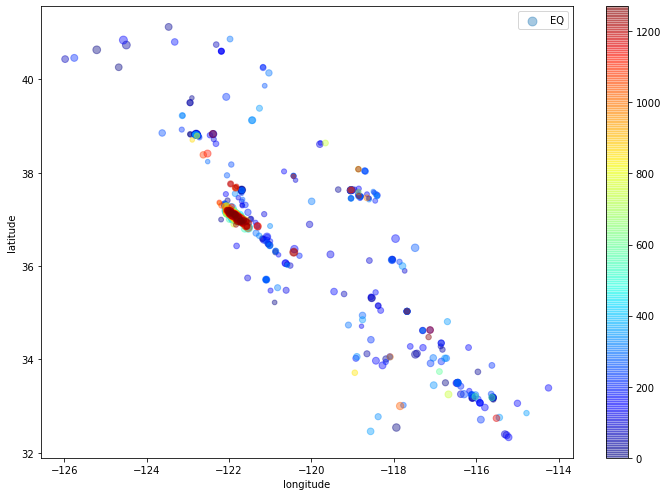

In [21]:
ax = plt.gca()


df_lp.plot(kind="scatter", x="longitude", y="latitude",
    s=df_lp['mag']/0.05, label="EQ",
    c=df_lp.index, cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7), ax = ax
)
plt.legend()

plt.tight_layout()

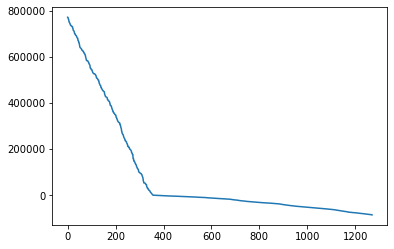

In [22]:
plt.plot(df_lp["time_to_failure_sec"])

# Building the model:

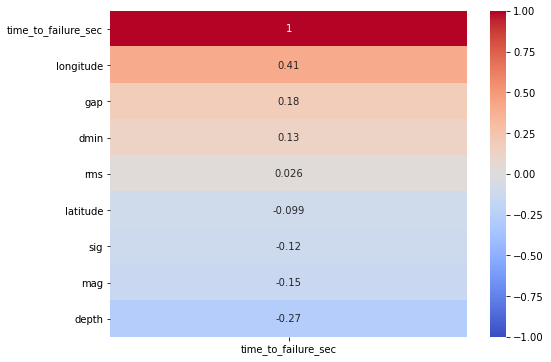

In [23]:
df_corr = df_lp.corr()

#plt.figure(figsize=(6,6))
plt.figure(figsize=(8,6))
sns.heatmap(df_corr[['time_to_failure_sec']].sort_values(by=['time_to_failure_sec'],ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True);
plt.savefig("../plots/Loma_prieta_EDA_corr_plots.png")

# LR model

### LINE Assumptions
The assumptions necessary to conduct a proper linear regression are easily remembered by the "LINE" acronym:

* L - Linearity: there is a linear relationship between x and y (fix: apply non-linear transformation)
* I - Independence of residuals (usually assumed)
* N - Normality: residuals are normally distributed (fix: log y variable)
* E - Equality of variance: residuals have constant variance (fix: check outliers, non-linear transformation)

In [24]:
df = df_lp.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1271 entries, 0 to 1270
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mag                  1271 non-null   float64
 1   sig                  1271 non-null   int64  
 2   dmin                 1153 non-null   float64
 3   rms                  1270 non-null   float64
 4   gap                  1270 non-null   float64
 5   magType              1271 non-null   object 
 6   longitude            1271 non-null   float64
 7   latitude             1271 non-null   float64
 8   depth                1271 non-null   float64
 9   time_to_failure_sec  1271 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 99.4+ KB


In [26]:
# Step 3: Instantiate the model
lr = LinearRegression()
# Step 1: Assemble our X and y variables

# We need an X matrix that is n-by-p (in this case, p = 1)


X = df_lp[["mag", "sig", "depth", "longitude", "latitude"]]

# We need a y vector that is length n
y = df_lp["time_to_failure_sec"]

lr.fit(X, y)

y_pred = lr.predict(X)

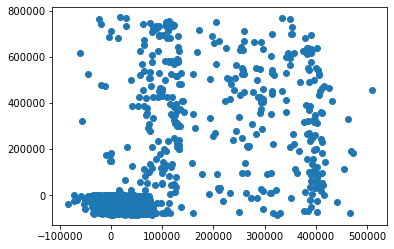

In [27]:
plt.scatter(y_pred, y)

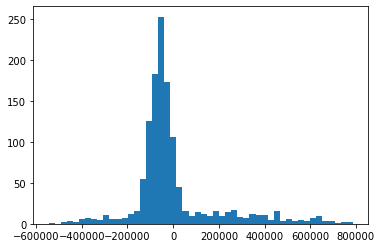

In [28]:
# Creat residuals
resids = y - y_pred
# N assumption:
plt.hist(resids, bins=50);

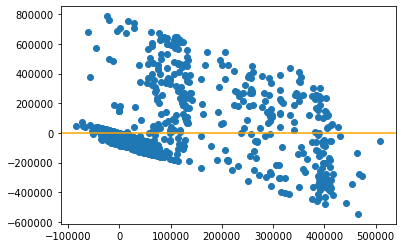

In [29]:
# L and E assumption
# our actual residuals
plt.scatter(y_pred, resids)
plt.axhline(0, color='orange');

In [30]:
lr.score(X, y)

0.29073012069721504

In [31]:
# Via sklearn.metrics
from sklearn import metrics


metrics.mean_absolute_error(y, y_pred)

122466.24017635341

In [32]:
import statsmodels.api as sm

X_sm = sm.add_constant(X)
ols = sm.OLS(y, X_sm).fit()

ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     time_to_failure_sec   R-squared:                       0.291
Model:                             OLS   Adj. R-squared:                  0.288
Method:                  Least Squares   F-statistic:                     103.7
Date:                 Mon, 28 Sep 2020   Prob (F-statistic):           8.23e-92
Time:                         12:16:01   Log-Likelihood:                -17236.
No. Observations:                 1271   AIC:                         3.448e+04
Df Residuals:                     1265   BIC:                         3.452e+04
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.087e+06   4.65e+05     19.524      0.000    8.17e+06       1e+07
mag        -1.604e+04   1.46e+04     -1.102      0.271   -4.46e+04    1.25e+04
sig           76.2451    154.233      0.494      0.621    -226.335     378.825
depth      -5057.9791   1094.358     -4.622      0.000   -7204.936   -2911.022
longitude   9.997e+04   5358.385     18.658      0.000    8.95e+04     1.1e+05
latitude    8.601e+04   7313.282     11.760      0.000    7.17e+04       1e+05
==============================================================================
Omnibus:                      400.941   Durbin-Watson:                   0.411
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1180.028
Skew:                           1.602   Prob(JB):                    5.76e-257
Kurtosis:                       6.467   Cond. No.                     1.32e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## The Linear Regression was not very good, now, trying the clustering idea.

# Clustering the AE events:

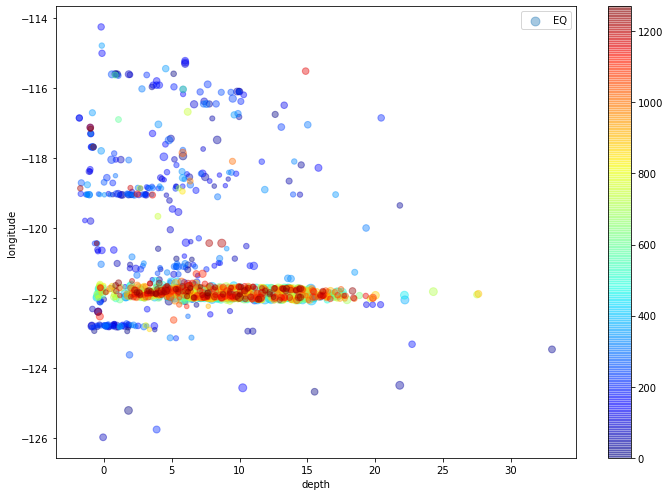

In [26]:
ax = plt.gca()

df_lp_eq.plot(kind="scatter", x="depth", y="longitude",
    s=df_lp_eq['mag']/0.05, label="EQ",
    c=df_lp_eq.index, cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7), ax = ax
)
plt.legend()

plt.tight_layout();

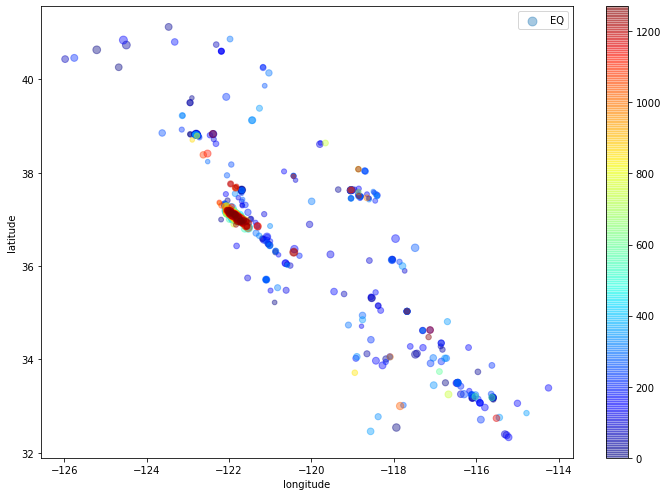

In [27]:
ax = plt.gca()


df_lp_eq.plot(kind="scatter", x="longitude", y="latitude",
    s=df_lp_eq['mag']/0.05, label="EQ",
    c=df_lp_eq.index, cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7), ax = ax
)
plt.legend()

plt.tight_layout()

In [28]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris, load_wine
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# 2D clusgering within long-lat : DBSCAN

In [29]:
df = df_lp_eq[["longitude", "latitude"]]

df.head()

,longitude,latitude
0,-125.212333,40.634000
1,-115.586000,33.144000
2,-117.939000,32.541000
3,-115.594000,33.177000
4,-124.678333,40.260333


Standardizing the data:

In [30]:
ss = StandardScaler()

X_scaled = ss.fit_transform(df)


Instantitating and fitting a DBSCAN:

In [31]:
dbscan = DBSCAN()

dbscan.fit(X_scaled);

model evaluation:

In [32]:
silhouette_score(X_scaled, dbscan.labels_)

0.628457964440217

In [33]:
df['cluster'] = dbscan.labels_

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<Figure size 1440x720 with 0 Axes>

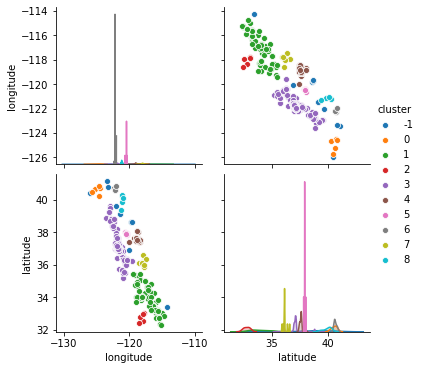

In [34]:
plt.figure(figsize = (20, 10))
sns.pairplot(df, hue='cluster')

In [35]:
df.head()

,longitude,latitude,cluster
0,-125.212333,40.634000,0
1,-115.586000,33.144000,1
2,-117.939000,32.541000,2
3,-115.594000,33.177000,1
4,-124.678333,40.260333,0


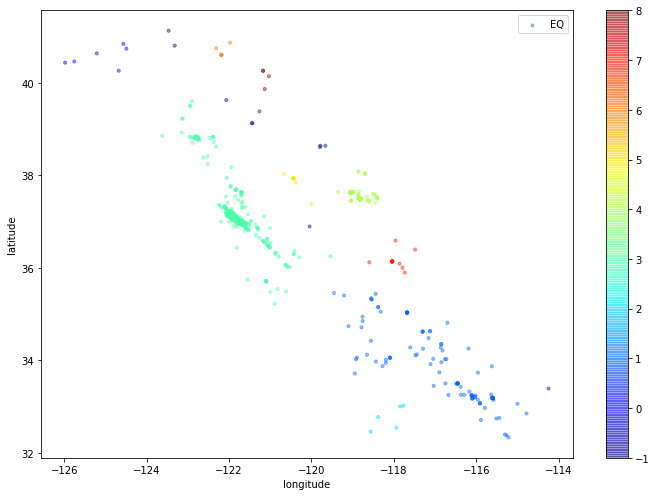

In [36]:
ax = plt.gca()


df.plot(kind="scatter", x="longitude", y="latitude",
    s=[10] * len(df),
    label="EQ",
    c=df["cluster"],
    cmap=plt.get_cmap("jet"),
    colorbar=True, 
    alpha=0.4, 
    figsize=(10,7), ax = ax
)

plt.legend()

plt.tight_layout()

# 3D clustering with long-lat-depth

In [37]:
df = df_lp_eq[["longitude", "latitude", "depth"]]

df.head()

,longitude,latitude,depth
0,-125.212333,40.634000,1.805
1,-115.586000,33.144000,5.137
2,-117.939000,32.541000,5.826
3,-115.594000,33.177000,0.985
4,-124.678333,40.260333,15.540


Standardizing the data:

In [38]:
ss = StandardScaler()

X_scaled = ss.fit_transform(df)


Instantitating and fitting a DBSCAN:

In [39]:
dbscan = DBSCAN()

dbscan.fit(X_scaled);

model evaluation:

In [40]:
silhouette_score(X_scaled, dbscan.labels_)

0.3346594441022797

In [41]:
df['cluster'] = dbscan.labels_

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<Figure size 1440x720 with 0 Axes>

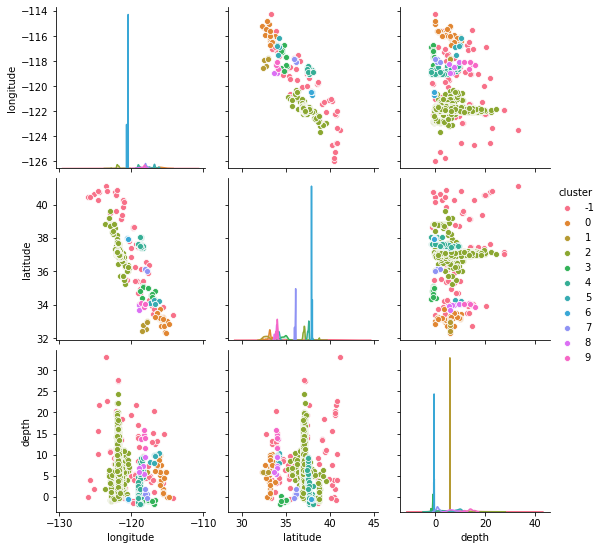

In [42]:
plt.figure(figsize = (20, 10))
sns.pairplot(df, hue='cluster')

In [43]:
df.head()

,longitude,latitude,depth,cluster
0,-125.212333,40.634000,1.805,-1
1,-115.586000,33.144000,5.137,0
2,-117.939000,32.541000,5.826,1
3,-115.594000,33.177000,0.985,0
4,-124.678333,40.260333,15.540,-1


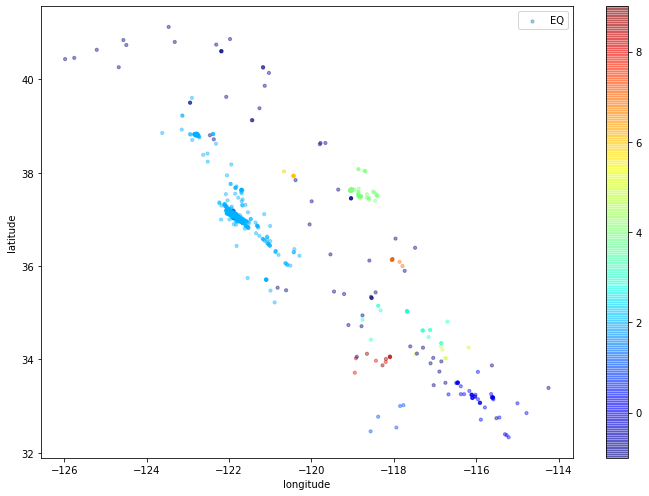

In [44]:
ax = plt.gca()


df.plot(kind="scatter", x="longitude", y="latitude",
    s=[10] * len(df),
    label="EQ",
    c=df["cluster"],
    cmap=plt.get_cmap("jet"),
    colorbar=True, 
    alpha=0.4, 
    figsize=(10,7), ax = ax
)

plt.legend()

plt.tight_layout()

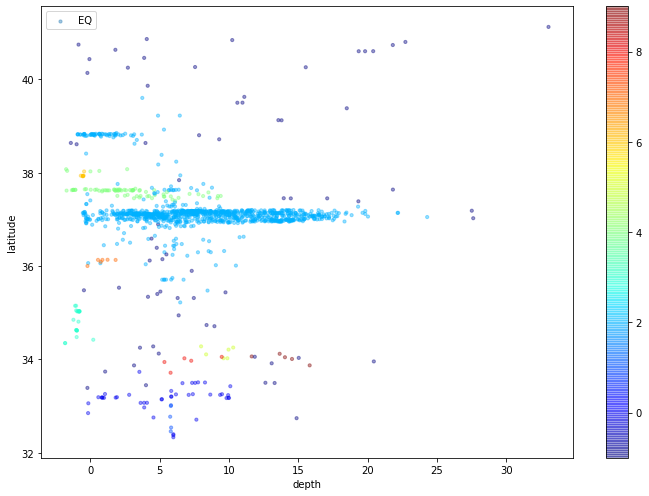

In [45]:
ax = plt.gca()


df.plot(kind="scatter", x="depth", y="latitude",
    s=[10] * len(df),
    label="EQ",
    c=df["cluster"],
    cmap=plt.get_cmap("jet"),
    colorbar=True, 
    alpha=0.4, 
    figsize=(10,7), ax = ax
)

plt.legend()

plt.tight_layout()

In [46]:
print("Hello World!")

Hello World!
